<a href="https://colab.research.google.com/github/AnilKumar-06/SentimentAnalysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gensim
!pip install tqdm

In [3]:
!pip install xgboost

In [4]:
import sqlite3
import numpy as np
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from sklearn.metrics import confusion_matrix, accuracy_score

## Utility function to save and load file

In [5]:
def savetofile(obj, fname):
    pickle.dump(obj, open(fname+'.p', 'wb'))

def openfromfile(fname):
    tmp = pickle.load(open(fname+'.p', 'rb'))
    return tmp

### Creating DataBase Connection to fetch the data

In [6]:
con = sqlite3.connect('/content/drive/MyDrive/Sentiment_Analysis/database.sqlite')
data = pd.read_sql_query("""SELECT *FROM Reviews WHERE Score != 3""", con)

In [7]:
#Filtering out the review with rating 3
def partition(x):
    if x < 3:
        return 0
    else:
        return 1
data['Score'] = data['Score'].apply(partition)

In [8]:
data['Score'] = data['Score'].replace(1,'Positive')
data['Score'] = data['Score'].replace(0,'Negative')

In [9]:

data.head(4)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


In [10]:
data.shape

(525814, 10)

In [11]:
data['Score'].value_counts()

Positive    443777
Negative     82037
Name: Score, dtype: int64

### Check and remove duplicates

In [12]:
data.duplicated(subset={'UserId', 'ProfileName', 'Time', 'Text'}).value_counts()

False    364173
True     161641
dtype: int64

In [13]:
data = data.drop_duplicates(subset = {'UserId', 'ProfileName', 'Time', 'Text'}, keep='first')

In [14]:
data.shape

(364173, 10)

In [15]:
data = data[data['HelpfulnessNumerator'] <= data['HelpfulnessDenominator']]

In [16]:
print("Data Size = {} Rows".format(data.shape[0]))

Data Size = 364171 Rows


### Data Cleaning

In [17]:
def strip_punc(df):
    ptrn = re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]')
    return ptrn.sub('', df)

In [18]:
strip_punc("fsd*?~,,,( sdfsdfdsvv)#")

'fsd sdfsdfdsvv'

In [19]:
def strip_html(sent):
    ptrn = re.compile('<.*?>')
    return ptrn.sub('', sent)

In [20]:
strip_html('<a href="foo.com" class="bar">I Want This <b>text!</b></a><>')

'I Want This text!'

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
stop = stopwords.words('english')
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop = [word for word in stop if stop not in excluding]
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [23]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english')
print("Stem words of some of the  english word using SnowBall Stemmer\nExamples:\n")
print(snow.stem('tasty'))
print(snow.stem('tasteful'))
print(snow.stem('tastiest'))
print(snow.stem('delicious'))
print(snow.stem('amazing'))

Stem words of some of the  english word using SnowBall Stemmer
Examples:

tasti
tast
tastiest
delici
amaz


In [24]:
def text_cleaning(data):
    i=0
    str1 = ''
    final_str = []
    pos_rev = []
    neg_rev = []
    s = ''
    for sent in data['Text']:
        filtered_sent = []
        #print(sent)
        sent = strip_html(sent)
        sent = strip_punc(sent)
        #print(sent.split())
        for word in sent.split():
            #print('\n')
            if(word.isalpha() and (len(word)>2)):
                if(word.lower() not in stop):
                    s = snow.stem(word.lower())
                    #print('stem word of {} is : {}'.format(word, s))
                    filtered_sent.append(s)
                    if((data['Score'].values)[i] == 'Positive'):
                        pos_rev.append(s)
                        #print('pos_rev')
                    if((data['Score'].values)[i] == 'Negative'):
                        neg_rev.append(s)
                        #print('neg_rev')
                else:
                    #print('stop word = ', word)
                    continue
            else:
                #print('Numerical value or single or just two character = ', word)
                continue
        str1 = " ".join(filtered_sent)
        final_str.append(str1)
    #print(final_str)
        i+=1
    return final_str

In [25]:
data['Cleaned_text'] = text_cleaning(data)

In [26]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanutsth peanu...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confect around centuri light pillowi citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...


In [27]:
data.shape

(364171, 11)

In [28]:
x = data['Cleaned_text']
y = data['Score']

In [29]:
eda_on_score = pd.DataFrame({'Score':y, 'Text':x})
eda_on_score.head()

,Score,Text
0,Positive,bought sever vital can dog food product found ...
1,Negative,product arriv label jumbo salt peanutsth peanu...
2,Positive,confect around centuri light pillowi citrus ge...
3,Negative,look secret ingredi robitussin believ found go...
4,Positive,great taffi great price wide assort yummi taff...


In [30]:
eda_on_score.shape

(364171, 2)

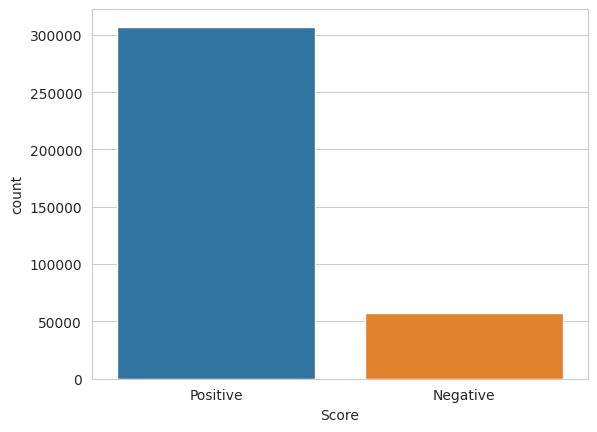

In [31]:
sns.set_style('whitegrid')
sns.countplot(x = 'Score', data = eda_on_score)
plt.show()

In [32]:
data['Score'] = data['Score'].replace('Positive', 1)
data['Score'] = data['Score'].replace('Negative', 0)

In [33]:
data.sort_values('Time', inplace=True)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [34]:
data = data[:10000]

In [35]:
data.shape

(10000, 11)

### Bag of Words

In [36]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression

In [37]:
x = data['Cleaned_text']
y = data['Score'].values
#X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)


In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle=False)


In [39]:
train = x_train.copy()
test = x_test.copy()

w2v_train_data = x_train.copy()
w2v_test_data = x_test.copy()

In [40]:
train[:2]

138706    witti littl book make son laugh loud recit car...
138683    rememb see show air televis year ago child sis...
Name: Cleaned_text, dtype: object

In [41]:
count_vect= CountVectorizer(ngram_range=(1,2), analyzer='word', max_features=5000)
sc = StandardScaler(with_mean=False)

bow_train = count_vect.fit_transform(x_train)
bow_train = sc.fit_transform(bow_train)
bow_train = preprocessing.normalize(bow_train)


bow_test = count_vect.transform(x_test)
bow_test = preprocessing.normalize(bow_test)
bow_test = sc.transform(bow_test)

In [42]:
print('Train Data = ', x_train.shape)
print('Test data = ', x_test.shape)

Train Data =  (8000,)
Test data =  (2000,)


In [43]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
#scv.split(x_train)

In [44]:
from sklearn.model_selection import GridSearchCV


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle=False)
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), analyzer='word', max_features=5000)
sc = StandardScaler(with_mean=False)

tfidf_train = tfidf_vect.fit_transform(train)
tfidf_train = preprocessing.normalize(tfidf_train)
#tfidf_train = sc.fit_transform(tfidf_train)

tfidf_test = tfidf_vect.transform(test)
tfidf_test = preprocessing.normalize(tfidf_test)
#tfidf_test = sc.transform(tfidf_test)

# Model Selection

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

In [47]:
def modelTreainer(x_train, x_test):
    try:
        models = {
            'Random Forest' : RandomForestClassifier(),
            'Logistic regression' : LogisticRegression(penalty ='l2', max_iter=1000),
            'Xgboost' : XGBClassifier(use_label_encoder=False,
                                    n_estimators=140,
                                    objective= 'binary:logistic',
                                    max_depth=5,
                                    min_child_weight=1,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    nthread=4,
                                    eval_metric='logloss'),

            'KNN' : KNeighborsClassifier(),
            'SVM' : SVC(),
            'Naive Bayes' : GaussianNB(),
        }

        params = {
            'Random Forest':{
                #'criterion':[],
                #'splitter':['best', 'random'],
                'max_features':['sqrt', 'log2'],
                'n_estimators':[8, 16, 32, 64]
            },


            'Logistic regression':{
              'C':[0.1, 0.01],
              'solver': ['newton-cg', 'lbfgs']
            },

            'Xgboost':{
                 'max_depth':range(3,8,2),
                 'min_child_weight':range(1,5,2)
            },


            'Naive Bayes':{
               # "gamma": [0.1, 1.0, 10],
                'var_smoothing': np.logspace(0,-9, num=2)
            },

            'KNN':{
                #leaf_size = list(range(1,50))
                'n_neighbors' : list(range(2,10))
               # p=[1,2]
            },


            'SVM':{
                'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01],
              #'kernel': ['rbf']
            }


        }

        model_report:dict=model_evaluate(x_train, y_train, x_test, y_test, models, params)
        best_model_score = max(sorted(model_report.values()))

        best_model_name = list(model_report.keys())[
            list(model_report.values()).index(best_model_score)
        ]

        best_model = models[best_model_name]
        pred = best_model.predict(x_test)
        score = accuracy_score(y_test, pred)

        return score
    except Exception as e:
        print(e)

# Model Evaluation

In [48]:
report = dict()
best_para = dict()
def model_evaluate(x_train, y_train, x_test, y_test, models, params):
    try:
        for i in range(len(list(models))):
            model = list(models.values())[i]
            para = params[list(models.keys())[i]]
            gs = GridSearchCV(model, para, cv=3)

            gs.fit(x_train, y_train)

            model.set_params(**gs.best_params_)

            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            model_score = accuracy_score(y_test, y_pred)
            report[list(models.keys())[i]] = model_score
            best_para[list(models.keys())[i]] = gs.best_params_

        return report

    except Exception as e:
        print(e)

In [49]:
# list(models)

### Utilizing GPU For model selection

In [50]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [51]:
tf.config.list_physical_devices('GPU')

[]

In [52]:
with tf.device('/GPU:0'):
  modelTreainer(bow_train.toarray(), bow_test.toarray())

In [53]:
print(bow_train.toarray, bow_test.toarray)

<bound method _cs_matrix.toarray of <8000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 272323 stored elements in Compressed Sparse Row format>> <bound method _cs_matrix.toarray of <2000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 56646 stored elements in Compressed Sparse Row format>>


In [54]:
pd.DataFrame(report, index=[1])

,Random Forest,Logistic regression,Xgboost,KNN,SVM,Naive Bayes
1,0.7545,0.9175,0.9035,0.8915,0.434,0.8665


In [55]:
best_para

{'Random Forest': {'max_features': 'sqrt', 'n_estimators': 32},
 'Logistic regression': {'C': 0.1, 'solver': 'newton-cg'},
 'Xgboost': {'max_depth': 3, 'min_child_weight': 1},
 'KNN': {'n_neighbors': 8},
 'SVM': {'C': 10, 'gamma': 0.1},
 'Naive Bayes': {'var_smoothing': 1e-09}}

### Logistic Regression with Bag of Word

In [56]:
bow_lr = LogisticRegression(penalty ='l2', max_iter=1000, C = 0.1, solver = 'newton-cg')
bow_lr.fit(bow_train.toarray(), y_train)

LogisticRegression(C=0.1, max_iter=1000, solver='newton-cg')

In [57]:
bow_lr_pred = bow_lr.predict(bow_test.toarray())

In [58]:
bow_lr.score(bow_test.toarray(), y_test)


0.9175

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test, bow_lr_pred))

              precision    recall  f1-score   support

           0       0.80      0.37      0.51       229
           1       0.92      0.99      0.95      1771

    accuracy                           0.92      2000
   macro avg       0.86      0.68      0.73      2000
weighted avg       0.91      0.92      0.90      2000



In [60]:
def conf_mat(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)

  sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='pink')
  #sns.heatmap(confusion, annot=True, fmt='0.2f', cmap='Blues')

  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

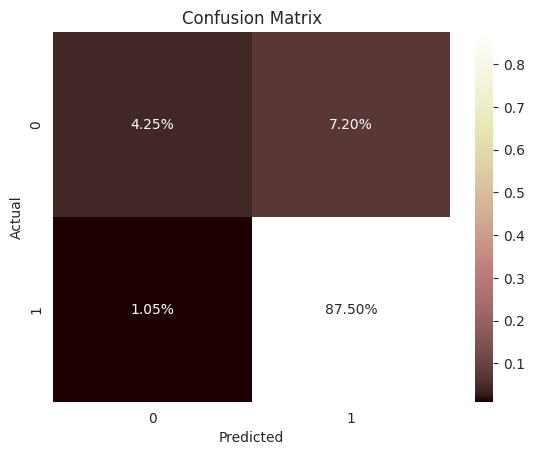

In [61]:
conf_mat(y_test, bow_lr_pred)

### XGBoost with Bag of Words

In [62]:
xgb_bow = XGBClassifier(use_label_encoder=False,
                                    n_estimators=140,
                                    objective= 'binary:logistic',
                                    max_depth=3,
                                    min_child_weight=1,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    nthread=4,
                                    eval_metric='logloss')

xgb_bow.fit(bow_train.toarray(), y_train)
xgb_pred = xgb_bow.predict(bow_test.toarray())

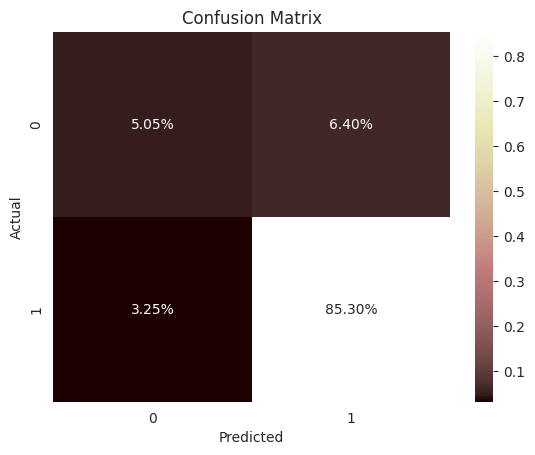

              precision    recall  f1-score   support

           0       0.61      0.44      0.51       229
           1       0.93      0.96      0.95      1771

    accuracy                           0.90      2000
   macro avg       0.77      0.70      0.73      2000
weighted avg       0.89      0.90      0.90      2000



In [63]:
conf_mat(y_test, xgb_pred)
print(classification_report(y_test, xgb_pred))

## Classifiers based on TF-IDF

In [64]:
with tf.device('/GPU:0'):
  modelTreainer(tfidf_train.toarray(), tfidf_test.toarray())

In [65]:
report

{'Random Forest': 0.902,
 'Logistic regression': 0.908,
 'Xgboost': 0.9055,
 'KNN': 0.885,
 'SVM': 0.8855,
 'Naive Bayes': 0.7325}

In [66]:
pd.DataFrame(report, index=[1])

,Random Forest,Logistic regression,Xgboost,KNN,SVM,Naive Bayes
1,0.902,0.908,0.9055,0.885,0.8855,0.7325


In [67]:
best_para

{'Random Forest': {'max_features': 'sqrt', 'n_estimators': 16},
 'Logistic regression': {'C': 0.01, 'solver': 'newton-cg'},
 'Xgboost': {'max_depth': 5, 'min_child_weight': 1},
 'KNN': {'n_neighbors': 5},
 'SVM': {'C': 1, 'gamma': 1},
 'Naive Bayes': {'var_smoothing': 1e-09}}

### Random forest with best parameters

In [68]:
rf_tfidf = RandomForestClassifier(max_features = 'sqrt', n_estimators = 32)
rf_tfidf.fit(tfidf_train.toarray(), y_train)
rf_tfidf_pred = rf_tfidf.predict(tfidf_test.toarray())

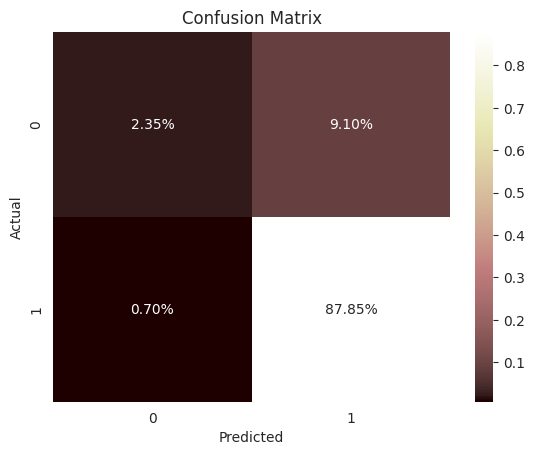

              precision    recall  f1-score   support

           0       0.77      0.21      0.32       229
           1       0.91      0.99      0.95      1771

    accuracy                           0.90      2000
   macro avg       0.84      0.60      0.64      2000
weighted avg       0.89      0.90      0.88      2000



In [69]:
conf_mat(y_test, rf_tfidf_pred)
print(classification_report(y_test, rf_tfidf_pred))

### Logistic Regression with best Parameters

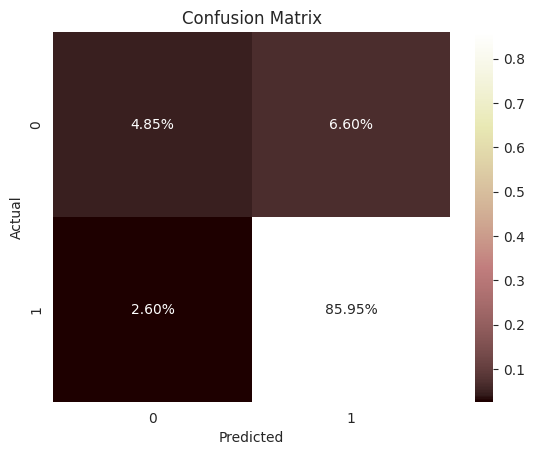

              precision    recall  f1-score   support

           0       0.65      0.42      0.51       229
           1       0.93      0.97      0.95      1771

    accuracy                           0.91      2000
   macro avg       0.79      0.70      0.73      2000
weighted avg       0.90      0.91      0.90      2000



In [70]:
lr_tfidf = LogisticRegression(penalty ='l2', max_iter=1000, C = 0.01, solver = 'newton-cg')
lr_tfidf.fit(tfidf_train.toarray(), y_train)

lr_tfidf_pred = lr_tfidf.predict(tfidf_test.toarray())
conf_mat(y_test, lr_tfidf_pred)
print(classification_report(y_test, lr_tfidf_pred))

### XGBoost with best Parameters

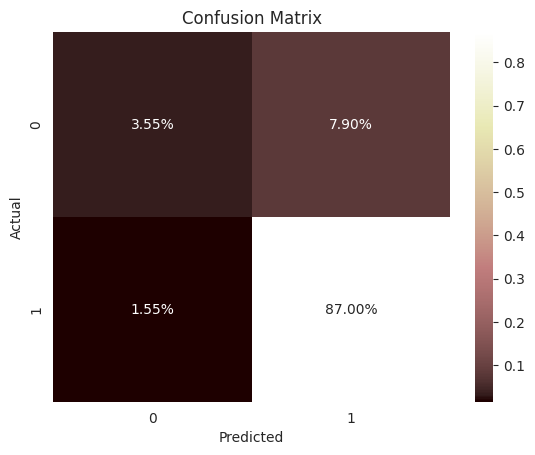

              precision    recall  f1-score   support

           0       0.70      0.31      0.43       229
           1       0.92      0.98      0.95      1771

    accuracy                           0.91      2000
   macro avg       0.81      0.65      0.69      2000
weighted avg       0.89      0.91      0.89      2000



In [71]:
xgb_tfidf = XGBClassifier(use_label_encoder=False,
                                    n_estimators=140,
                                    objective= 'binary:logistic',
                                    max_depth=5,
                                    min_child_weight=1,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    nthread=4,
                                    eval_metric='logloss')
xgb_tfidf.fit(tfidf_train.toarray(), y_train)

xgb_tfidf_pred = xgb_tfidf.predict(tfidf_test.toarray())
conf_mat(y_test, xgb_tfidf_pred)
print(classification_report(y_test, xgb_tfidf_pred))

## Average word2Vec

In [72]:
x_1, x_test, y_1, y_test = train_test_split(x, y, test_size = 0.15, shuffle=False)
x_train, x_cv, y_train, y_cv = train_test_split(x_1, y_1, test_size = 0.15, shuffle=False)

In [73]:
import gensim
w2v_train_data = x_train.copy()
w2v_test_data = x_test.copy()
w2v_cv_data = x_train.copy()

In [74]:
#w2v_train_data.shape
w2v_train_data.shape

(7225,)

In [75]:
print(y_train.shape, y_cv.shape)

(7225,) (1275,)


## AVG Word2Vec

In [77]:
# For training data
i=0
sent_list = []
for sent in w2v_train_data:
    sent_list.append(sent.split())

w2v_model = Word2Vec(sent_list, min_count=5, vector_size=50, workers=8)
w2v_words = list(w2v_model.wv.index_to_key)

train_sent_vect = []
for sent in tqdm(sent_list):
    sent_vec = np.zeros(50)
    cnt_wrd = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_wrd += 1
    if cnt_wrd != 0:
      sent_vec /= cnt_wrd
    train_sent_vect.append(sent_vec)

100%|██████████| 7225/7225 [00:06<00:00, 1035.76it/s]


In [78]:
#ram_gt_8gb = True
want_google_w2v = True
want_train_w2v = True

if want_train_w2v:
    w2v_model = Word2Vec(sent_list, min_count=5, vector_size=50, workers=8)
    print(w2v_model.wv.most_similar('great'))
    print('*'*100)
    print()
    print(w2v_model.wv.most_similar('worst'))

elif(want_google_w2v):
    if(os.path.isfile('GoogleNews-vectors-negative300.bin')):
        w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")



[('good', 0.9341784119606018), ('pretti', 0.8286795616149902), ('excel', 0.8229870200157166), ('isnt', 0.8209074139595032), ('that', 0.8124854564666748), ('fantast', 0.7969174981117249), ('puf', 0.7929225564002991), ('healthier', 0.7928289175033569), ('pretzel', 0.7917848825454712), ('overal', 0.7917772531509399)]
****************************************************************************************************

[('bore', 0.9890450239181519), ('lollipop', 0.9885339140892029), ('serious', 0.988024115562439), ('grew', 0.987969160079956), ('disgust', 0.9870252013206482), ('man', 0.9862127304077148), ('kinda', 0.9853329062461853), ('theyd', 0.9845834374427795), ('aw', 0.9844064712524414), ('neither', 0.9839569926261902)]


In [79]:
w2v_words = list(w2v_model.wv.index_to_key)
print('number of words that occured minimum 5 times = ', len(w2v_words))
print('\nsample words = ',w2v_words[0:20])

number of words that occured minimum 5 times =  4285

sample words =  ['tea', 'like', 'tast', 'flavor', 'good', 'one', 'use', 'great', 'tri', 'love', 'make', 'product', 'get', 'coffe', 'eat', 'best', 'also', 'time', 'food', 'realli']


In [80]:
sent_list_of_train = []
for sent in w2v_train_data:
    sent_list_of_train.append(sent.split())

w2v_model = Word2Vec(sent_list_of_train, min_count=5, vector_size=50, workers=8)
w2v_words = list(w2v_model.wv.index_to_key)

train_sent_vect = []
for sent in tqdm(sent_list_of_train):
    sent_vec = np.zeros(50)
    cnt_wrd = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_wrd += 1
    if cnt_wrd != 0:
        sent_vec /= cnt_wrd
    train_sent_vect.append(sent_vec)



#for test data
sent_list_of_test = []
for sent in w2v_test_data:
    sent_list_of_test.append(sent.split())

test_sent_vect = []
for sent in tqdm(sent_list_of_test):
    sent_vec = np.zeros(50)
    cnt_wrd = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_wrd += 1
    if cnt_wrd != 0:
        sent_vec /= cnt_wrd
    test_sent_vect.append(sent_vec)


# for cv data
sent_list_of_cv = []
for sent in w2v_cv_data:
    sent_list_of_cv.append(sent.split())

cv_sent_vect = []
for sent in tqdm(sent_list_of_cv):
    sent_vec = np.zeros(50)
    cnt_wrd = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_wrd += 1
    if cnt_wrd != 0:
        sent_vec /= cnt_wrd
    cv_sent_vect.append(sent_vec)


100%|██████████| 7225/7225 [00:06<00:00, 1119.93it/s]


In [81]:
x_train_w2v=train_sent_vect
x_cv_w2v=cv_sent_vect
x_test_w2v=test_sent_vect

In [82]:
import tensorflow as tf
with tf.device('/GPU:0'):
  modelTreainer(x_train_w2v, x_test_w2v)

In [83]:
pd.DataFrame(report, index=[1])

,Random Forest,Logistic regression,Xgboost,KNN,SVM,Naive Bayes
1,0.875333,0.877333,0.873333,0.874667,0.877333,0.782667


In [84]:
report

{'Random Forest': 0.8753333333333333,
 'Logistic regression': 0.8773333333333333,
 'Xgboost': 0.8733333333333333,
 'KNN': 0.8746666666666667,
 'SVM': 0.8773333333333333,
 'Naive Bayes': 0.7826666666666666}

## TFIDF W2V

In [85]:
sent_list_of_train = []
for sent in w2v_train_data:
    sent_list_of_train.append(sent.split())

w2v_model = Word2Vec(sent_list, min_count=5, vector_size=50, workers=8)
w2v_words = list(w2v_model.wv.index_to_key)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=5000)

tf_idf_matrix=tf_idf_vect.fit_transform(x_train)


tfidf_feat = tf_idf_vect.get_feature_names_out()
dictionary = dict(zip(tf_idf_vect.get_feature_names_out(), list(tf_idf_vect.idf_)))

train_tfidf_sent_vect = []
row = 0
for sent in tqdm(sent_list_of_train):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec*tf_idf
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vect.append(sent_vec)
    row += 1



#for test data
sent_list_of_test = []
for sent in w2v_test_data:
    sent_list_of_test.append(sent.split())

test_tfidf_sent_vect = []
row = 0
for sent in tqdm(sent_list_of_test):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec*tf_idf
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vect.append(sent_vec)
    row += 1


# for cv data
sent_list_of_cv = []
for sent in w2v_cv_data:
    sent_list_of_cv.append(sent.split())

cv_tfidf_sent_vect = []
row = 0
for sent in tqdm(sent_list_of_cv):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec*tf_idf
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_tfidf_sent_vect.append(sent_vec)
    row += 1

100%|██████████| 7225/7225 [00:54<00:00, 132.94it/s]


In [86]:
x_train_tfidf_w2v=train_tfidf_sent_vect
x_cv_tfidf_w2v=cv_tfidf_sent_vect
x_test_tfidf_w2v=test_tfidf_sent_vect

In [87]:
with tf.device('/GPU:0'):
  modelTreainer(x_train_tfidf_w2v, x_test_tfidf_w2v)

In [88]:
pd.DataFrame(report, index=[1])

,Random Forest,Logistic regression,Xgboost,KNN,SVM,Naive Bayes
1,0.876667,0.877333,0.869333,0.873333,0.877333,0.776


In [89]:
report

{'Random Forest': 0.8766666666666667,
 'Logistic regression': 0.8773333333333333,
 'Xgboost': 0.8693333333333333,
 'KNN': 0.8733333333333333,
 'SVM': 0.8773333333333333,
 'Naive Bayes': 0.776}

# LSTM

In [90]:
!pip install tensorflow

In [91]:
lstm_train = x_train.copy()
lstm_test = x_test.copy()

In [92]:
lstm_train[:2]

138706    witti littl book make son laugh loud recit car...
138683    rememb see show air televis year ago child sis...
Name: Cleaned_text, dtype: object

In [93]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Embedding, Bidirectional, Dropout, GlobalAveragePooling1D, GRU

In [101]:
max_words = 5000
max_length = 500
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words = max_words,
                      oov_token = oov_tok)

tokenizer.fit_on_texts(lstm_train)

In [103]:
# word_idx = tokenizer.word_index
# total_word = len(word_index)

# total_words

In [104]:
x_train_lstm = tokenizer.texts_to_sequences(lstm_train)
x_test_lstm = tokenizer.texts_to_sequences(lstm_test)

In [105]:
train_lstm_pad = sequence.pad_sequences(x_train_lstm, padding = 'pre', maxlen=max_length)
test_lstm_pad = sequence.pad_sequences(x_test_lstm, padding = 'pre',  maxlen=max_length)

train_lstm_pad = np.array(train_lstm_pad).astype('float32')
test_lstm_pad = np.array(test_lstm_pad).astype('float32')
#np.asarray(y_test).astype('float32').reshape((-1,1))

In [106]:
print(train_lstm_pad.shape)
#print(train_lstm_pad[1])

(7225, 500)


In [107]:
def dynamic_plot(x, val_y, tr_y, ax, colors=['b']):
    ax.plot(x, val_y, 'b', label = 'Val Loss')
    ax.plot(x, tr_y, 'r', label = 'Train Loss')
    plt.legend()
    plt.grid()
    plt.show()

final_output = pd.DataFrame(columns=['Model', 'Archetecture', 'Train Loss',
                                    'Test Loss', 'Train Acc', 'Test Acc'])

In [108]:
!pip install keras_tuner

### Tunning Hyperparameter for LSTM

In [118]:

def build_model(hp):
    model = Sequential()

    cnt = 0
    for i in range(hp.Int('num_layers_', min_value = 1, max_value = 10)):
      if cnt == 0:
        #model.add(Embedding(input_dim=max_words, output_dim=hp.Int('embedding_dim', min_value=32, max_value=256, step=32), input_length=max_sequence_length))

        model.add(Embedding(input_dim=max_words, output_dim = 500, input_length=max_length))
      else:
          model.add(

                LSTM(units=hp.Int('lstm_units_'+str(i), min_value=1, max_value=10, step=1), return_sequences=True)
          )
          model.add(
              Dropout(rate=hp.Float('dropout_'+str(i), min_value=0.2, max_value=0.5, step=0.1)
          ))

      cnt += 1

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=hp.Choice('optimizer', values=['rmsprop', 'adam', 'nadam', 'adadelta']),
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [119]:
import keras_tuner as kt
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials = 1,
    directory='/content/drive/MyDrive/Sentiment_Analysis/mydir_0',
    project_name = 'final'
)

In [120]:
print(train_lstm_pad.shape, test_lstm_pad.shape)
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

(7225, 500) (1500, 500)


In [121]:
tuner.search(train_lstm_pad, y_train, epochs=5, validation_data=(test_lstm_pad, y_test))

Trial 1 Complete [00h 25m 35s]
val_accuracy: 0.8773333430290222

Best val_accuracy So Far: 0.8773333430290222
Total elapsed time: 00h 25m 35s


### Tuning hyperparameter for GRU

In [122]:
from traitlets.traitlets import Float
def build_model_with_GRU(hp):
    model = Sequential()

    cnt = 0
    for i in range(hp.Int('num_layers', min_value = 1, max_value = 10)):
      if cnt == 0:
        #model.add(Embedding(input_dim=max_words, output_dim=hp.Int('embedding_dim', min_value=32, max_value=256, step=32), input_length=max_sequence_length))

        model.add(Embedding(input_dim=max_words, output_dim = 500, input_length=max_length))

      else:
          model.add(
              GRU(units=hp.Int('gru_units'+str(i), min_value=1, max_value=10, step=1), return_sequences=True, recurrent_dropout = 0.25, dropout=0.25)
          ),

          GlobalAveragePooling1D(),

         # Dense(units=hp.Int('dense_units'+str(i), min_value=1, max_value=10, step=1), activation='relu')

          model.add(
              Dropout(rate=hp.Float('dropout'+str(i), min_value=0.2, max_value=0.5, step=0.1)
          ))

      cnt += 1

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=hp.Choice('optimizer', values=['rmsprop', 'adam', 'nadam', 'adadelta']),
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [123]:
import keras_tuner as kt
tuner = kt.RandomSearch(
    build_model_with_GRU,
    objective='val_accuracy',
    max_trials = 1,
    directory='/content/drive/MyDrive/Sentiment_Analysis/GRU_dir',
    project_name = 'GRU'
)

In [124]:
print(train_lstm_pad.shape, test_lstm_pad.shape)
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

(7225, 500) (1500, 500)


In [125]:
 tuner.search(train_lstm_pad, y_train, epochs=5, validation_data=(test_lstm_pad, y_test))

Trial 1 Complete [00h 26m 37s]
val_accuracy: 0.8777666091918945

Best val_accuracy So Far: 0.8777666091918945
Total elapsed time: 00h 26m 37s
